# Quantum Circuit Learning 
## Classification Task

Import basic modules

In [1]:
# Data
import numpy as np
from sklearn.datasets import make_circles

# Plots
import matplotlib.pyplot as plt
%matplotlib inline  
from matplotlib.colors import ListedColormap

In this example, QCL will try to perform a simple nonlinear classification task. The data points belong to two classes 0 (red dots) and 1 (blue dots).

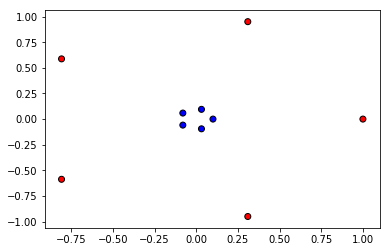

In [2]:
#==============================================================================
# Generate data and labels
#==============================================================================
np.random.seed(0)
m = 10
X, y = make_circles(n_samples=m, factor=.1, noise=.0, random_state=0)
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright, edgecolors='k')

Next, we produce a function generating input, output and gradient states. The default methods included in QCL can be used. As the input data for i-th sample is two dimensional we use the following unitary: $$U_0(x_i) = \prod_{k=1}^N R_X^k(\cos(x_{i,j'}^2))R_Y^k(\sin(x_{i,j'}))$$ where $$j' = j\text{ }mod\text{ }2$$ i.e. the remainder of j divided by 2 and $$(x_{i,1}, x_{i,2})$$ are the coordinates of a training sample.

In [3]:
#==============================================================================
# Programs
#============================================================================== 
from .qcl import (ising_prog_gen, default_input_state_gen, 
                 default_output_state_gen, default_grad_state_gen)

n_qubits, depth = 4, 4

ising_prog = ising_prog_gen(trotter_steps=1000, T=10, n_qubits=n_qubits)
state_generators = dict()
state_generators['input'] = default_input_state_gen(n_qubits)
state_generators['output'] = default_output_state_gen(ising_prog, n_qubits, depth)
state_generators['grad'] = default_grad_state_gen(ising_prog, n_qubits, depth)

We increase the number of qubits and depth of quantum circuit in comparison to regression task to get a better fit. The output is taken from expectation values of observables Z on the first and the second qubit and we use [binary crossentropy](https://en.wikipedia.org/wiki/Cross_entropy) as a loss function minimized. For binary crossentropy loss function the expectation values are transformed by [softmax function](https://en.wikipedia.org/wiki/Softmax_function) to get valid probabilities, however, this is done inside the optimizer.py.

In [4]:
#==============================================================================
# Quantum Circuit Learning - Classification 
#==============================================================================
import .qsimulator as pq
from .qsimulator import Z
from .qcl import QCL

initial_theta = np.random.uniform(0.0, 2*np.pi, size=3*n_qubits*depth)

operator1 = pq.Program(n_qubits)
operator1.inst(Z, 0)
operator2 = pq.Program(n_qubits)
operator2.inst(Z, 1)
operator_programs = [operator1, operator2] 

est = QCL(state_generators, initial_theta, loss="binary_crossentropy",  
          operator_programs=operator_programs, epochs=20, batch_size=m,
          verbose=True)

est.fit(X,y)
results = est.get_results()

Epoch: 1/20 ::: Batch: 1/1 ::: Loss: 0.70658
Epoch: 2/20 ::: Batch: 1/1 ::: Loss: 0.60505
Epoch: 3/20 ::: Batch: 1/1 ::: Loss: 0.55402
Epoch: 4/20 ::: Batch: 1/1 ::: Loss: 0.52433
Epoch: 5/20 ::: Batch: 1/1 ::: Loss: 0.50417
Epoch: 6/20 ::: Batch: 1/1 ::: Loss: 0.48878
Epoch: 7/20 ::: Batch: 1/1 ::: Loss: 0.47640
Epoch: 8/20 ::: Batch: 1/1 ::: Loss: 0.46634
Epoch: 9/20 ::: Batch: 1/1 ::: Loss: 0.45817
Epoch: 10/20 ::: Batch: 1/1 ::: Loss: 0.45154
Epoch: 11/20 ::: Batch: 1/1 ::: Loss: 0.44615
Epoch: 12/20 ::: Batch: 1/1 ::: Loss: 0.44171
Epoch: 13/20 ::: Batch: 1/1 ::: Loss: 0.43800
Epoch: 14/20 ::: Batch: 1/1 ::: Loss: 0.43484
Epoch: 15/20 ::: Batch: 1/1 ::: Loss: 0.43210
Epoch: 16/20 ::: Batch: 1/1 ::: Loss: 0.42965
Epoch: 17/20 ::: Batch: 1/1 ::: Loss: 0.42744
Epoch: 18/20 ::: Batch: 1/1 ::: Loss: 0.42539
Epoch: 19/20 ::: Batch: 1/1 ::: Loss: 0.42347
Epoch: 20/20 ::: Batch: 1/1 ::: Loss: 0.42166


Now, we can plot the decision surface of a fitted QCL estimator. As we see the QCL fits sufficiently to the data. We can increase the predictive force by increasing number of qubits and depth of quantum circuit.

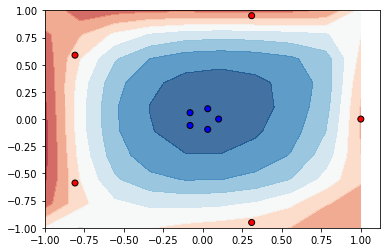

In [5]:
#==============================================================================
# PLot results
#==============================================================================
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
xx, yy = np.meshgrid(np.linspace(-1.0, 1.0, 10),
                     np.linspace(-1.0, 1.0, 10))
y_pred = est.predict(np.c_[xx.ravel(), yy.ravel()])[:,0]
Z = y_pred.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=cm, alpha=.8)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright, edgecolors='k')